In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [24]:
df=pd.read_csv('/content/drive/MyDrive/Gall_Bladder_Disorders_AI - sheet-1.csv')
df2=pd.read_csv('/content/drive/MyDrive/Test_data_version1.xlsx - Sheet1.csv')



In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150 entries, 0 to 2149
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Patient_ID              2150 non-null   object 
 1   GALL_BLADDER_DISORDERS  2150 non-null   float64
 2   CHOLESTEROL_DISORDERS   2150 non-null   float64
 3   OBESITY                 2150 non-null   float64
dtypes: float64(3), object(1)
memory usage: 67.3+ KB


In [26]:
df

,Patient_ID,GALL_BLADDER_DISORDERS,CHOLESTEROL_DISORDERS,OBESITY
0,KHAIGHGPTTL155,1.093394e+09,1.549463e+09,2.130295e+08
1,KHAIGHGPTTL156,5.465359e+08,2.837003e+09,2.128695e+08
2,KHAIGHGPTTL157,7.287913e+08,1.792181e+09,1.823782e+08
3,KHAIGHGPTTL158,3.646029e+08,1.276290e+09,2.008906e+08
4,KHAIGHGPTTL159,5.465819e+08,1.306413e+09,6.074028e+08
...,...,...,...,...
2145,KHTRCLGPTTL52,5.467200e+08,2.248475e+09,2.129232e+08
2146,KHYUNQGPTTL10,3.647641e+08,1.154046e+09,4.610059e+04
2147,KHYUNQGPTTL11,2.304190e+05,1.034231e+09,0.000000e+00
2148,KHAIGPRX1340,0.000000e+00,0.000000e+00,5.378402e+04


In [27]:
df2['Patient_ID'].isna().sum()

0

In [28]:
merged = pd.merge(df, df2[['Patient_ID', 'Gall bladder disorders']], on='Patient_ID', how='left')

In [29]:
from math import nan
merged['Gall bladder disorders'].replace(nan, '0', inplace=True)

In [30]:
merged.head()

,Patient_ID,GALL_BLADDER_DISORDERS,CHOLESTEROL_DISORDERS,OBESITY,Gall bladder disorders
0,KHAIGHGPTTL155,1.093394e+09,1.549463e+09,213029455.7,0
1,KHAIGHGPTTL156,5.465359e+08,2.837003e+09,212869484.1,0
2,KHAIGHGPTTL157,7.287913e+08,1.792181e+09,182378235.0,0
3,KHAIGHGPTTL158,3.646029e+08,1.276290e+09,200890586.5,0
4,KHAIGHGPTTL159,5.465819e+08,1.306413e+09,607402840.0,0


In [31]:
merged.describe()

,GALL_BLADDER_DISORDERS,CHOLESTEROL_DISORDERS,OBESITY
count,2.150000e+03,2.150000e+03,2.150000e+03
mean,4.452500e+08,1.441989e+09,2.388381e+08
std,2.340246e+08,5.175504e+08,1.845052e+08
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.644186e+08,1.123519e+09,1.822553e+08
50%,3.831383e+08,1.489489e+09,2.008828e+08
75%,5.652093e+08,1.792262e+09,3.948617e+08
max,1.305496e+09,3.108917e+09,1.062957e+09


In [32]:
X=merged[['GALL_BLADDER_DISORDERS','CHOLESTEROL_DISORDERS','OBESITY']]
y=merged[[ 'Gall bladder disorders']]

# SET 1

In [33]:
import numpy as np

y_set1 = y.copy()
y_set1['Gall bladder disorders'] = np.select(
    [
        y_set1['Gall bladder disorders'].isin(['Low','Low to Mild']),
        y_set1['Gall bladder disorders'].isin(['Mild']),
        y_set1['Gall bladder disorders'].isin(['Mild to Moderate','Moderate']),
        # y_set3['Mood Disorders- Anxiety, Schizophrenia, Depression'].isin(['Moderate to High'])
    ],
    ['Low', 'Mild','Moderate'],
    default= y_set1['Gall bladder disorders']
)


y_set1['Gall bladder disorders'].replace('0', -1, inplace=True)
y_set1['Gall bladder disorders'].replace('-',-1,inplace=True)

In [34]:
y_set1['Gall bladder disorders'].unique()

array([-1, 'Low', 'Mild', 'Moderate'], dtype=object)

In [36]:
from sklearn.preprocessing import LabelEncoder

# Encode labels for categorical values
encoder = LabelEncoder()
y_encoded_set1 = y_set1['Gall bladder disorders'].copy()

# Replace -1 (unlabeled) with NaN for encoding
y_encoded_set1.replace(-1, None, inplace=True)

# Apply LabelEncoder to known labels
encoded_labels = encoder.fit_transform(y_encoded_set1.dropna())

# Assign encoded labels back to the original DataFrame using the index
y_encoded_set1[y_encoded_set1.notna()] = encoded_labels

# Convert back to -1 for unlabeled
y_encoded_set1.fillna(-1, inplace=True)
print("Encoded Labels: ", y_encoded_set1.unique())

Encoded Labels:  [-1  0  1  2]


In [37]:
from sklearn.semi_supervised import LabelPropagation

labels_combined = y_encoded_set1.values.astype(int)

label_spread = LabelPropagation(kernel='knn')
label_spread.fit(X.values, labels_combined)

y_encoded_set1_propagated = label_spread.transduction_

known_indices = y_encoded_set1 != -1
accuracy = (y_encoded_set1[known_indices] == y_encoded_set1_propagated[known_indices]).mean()
print("Label Propagation Accuracy on Known Labels:", accuracy)


Label Propagation Accuracy on Known Labels: 1.0


In [39]:
unlabeled_indices = (y_encoded_set1 == -1)

propagated_labels_for_unlabeled = y_encoded_set1_propagated[unlabeled_indices]

print("Propagated Labels for Unlabeled Data:")
print(propagated_labels_for_unlabeled)


Propagated Labels for Unlabeled Data:
[2 2 0 ... 0 1 0]


In [40]:
import pandas as pd

df_with_propagated_labels = y_set1.copy()
df_with_propagated_labels['Propagated Labels'] = y_encoded_set1.copy()

df_with_propagated_labels.loc[unlabeled_indices, 'Propagated Labels'] = propagated_labels_for_unlabeled

df_with_propagated_labels['Propagated Labels'] = df_with_propagated_labels['Propagated Labels'].astype(int)

print(df_with_propagated_labels.head())

df_with_propagated_labels.to_csv('updated_with_propagated_labels.csv', index=False)


  Gall bladder disorders  Propagated Labels
0                     -1                  2
1                     -1                  2
2                     -1                  0
3                     -1                  0
4                     -1                  0


In [41]:
final_labeled=merged.copy()
final_labeled['new_labels']=df_with_propagated_labels['Propagated Labels']

In [42]:
final_labeled.to_csv("/content/drive/MyDrive/Mood Disorders AI/new_labels_mood_diorders_set1.csv", index=False)

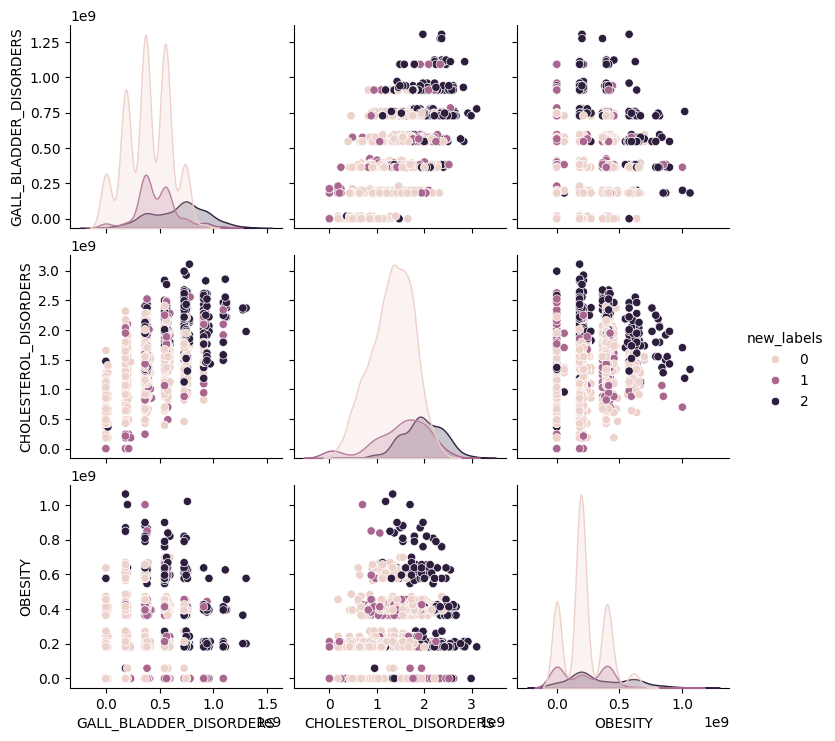

In [43]:
sns.pairplot(final_labeled, hue='new_labels')

# SET 2

In [53]:
import numpy as np

y_set2 = y.copy()
y_set2['Gall bladder disorders'] = np.select(
    [
        y_set2['Gall bladder disorders'].isin(['Low','Low to Mild',]),
        y_set2['Gall bladder disorders'].isin(['Mild','Mild to Moderate']),
        y_set2['Gall bladder disorders'].isin(['Moderate']),
        y_set2['Gall bladder disorders'].isin(['Moderate to High'])
    ],
    ['Low', 'Mild','Moderate','Moderate to High'],
    default= y_set2['Gall bladder disorders']
)


y_set2['Gall bladder disorders'].replace('0', -1, inplace=True)
y_set2['Gall bladder disorders'].replace('-',-1,inplace=True)

In [54]:
y_set2['Gall bladder disorders'].unique()

array([-1, 'Low', 'Mild', 'Moderate'], dtype=object)

In [55]:
from sklearn.preprocessing import LabelEncoder

# Encode labels for categorical values
encoder = LabelEncoder()
y_encoded_set2 = y_set2['Gall bladder disorders'].copy()

# Replace -1 (unlabeled) with NaN for encoding
y_encoded_set2.replace(-1, None, inplace=True)

# Apply LabelEncoder to known labels
encoded_labels = encoder.fit_transform(y_encoded_set2.dropna())

# Assign encoded labels back to the original DataFrame using the index
y_encoded_set2[y_encoded_set2.notna()] = encoded_labels

# Convert back to -1 for unlabeled
y_encoded_set2.fillna(-1, inplace=True)
print("Encoded Labels: ", y_encoded_set2.unique())

Encoded Labels:  [-1  0  1  2]


In [57]:
from sklearn.semi_supervised import LabelPropagation

labels_combined = y_encoded_set2.values.astype(int)

label_spread = LabelPropagation(kernel='knn')
label_spread.fit(X.values, labels_combined)

y_encoded_set2_propagated = label_spread.transduction_

known_indices = y_encoded_set2 != -1
accuracy = (y_encoded_set2[known_indices] == y_encoded_set2_propagated[known_indices]).mean()
print("Label Propagation Accuracy on Known Labels:", accuracy)


Label Propagation Accuracy on Known Labels: 1.0


In [58]:
unlabeled_indices = (y_encoded_set2 == -1)

propagated_labels_for_unlabeled = y_encoded_set2_propagated[unlabeled_indices]

print("Propagated Labels for Unlabeled Data:")
print(propagated_labels_for_unlabeled)


Propagated Labels for Unlabeled Data:
[2 2 0 ... 0 1 0]


In [59]:
import pandas as pd

df_with_propagated_labels = y_set2.copy()
df_with_propagated_labels['Propagated Labels'] = y_encoded_set2.copy()

df_with_propagated_labels.loc[unlabeled_indices, 'Propagated Labels'] = propagated_labels_for_unlabeled

df_with_propagated_labels['Propagated Labels'] = df_with_propagated_labels['Propagated Labels'].astype(int)

print(df_with_propagated_labels.head())

df_with_propagated_labels.to_csv('updated_with_propagated_labels.csv', index=False)


  Gall bladder disorders  Propagated Labels
0                     -1                  2
1                     -1                  2
2                     -1                  0
3                     -1                  0
4                     -1                  0


In [60]:
final_labeled=merged.copy()
final_labeled['new_labels']=df_with_propagated_labels['Propagated Labels']

In [61]:
final_labeled.to_csv("/content/drive/MyDrive/Mood Disorders AI/new_labels_mood_diorders_set2.csv", index=False)

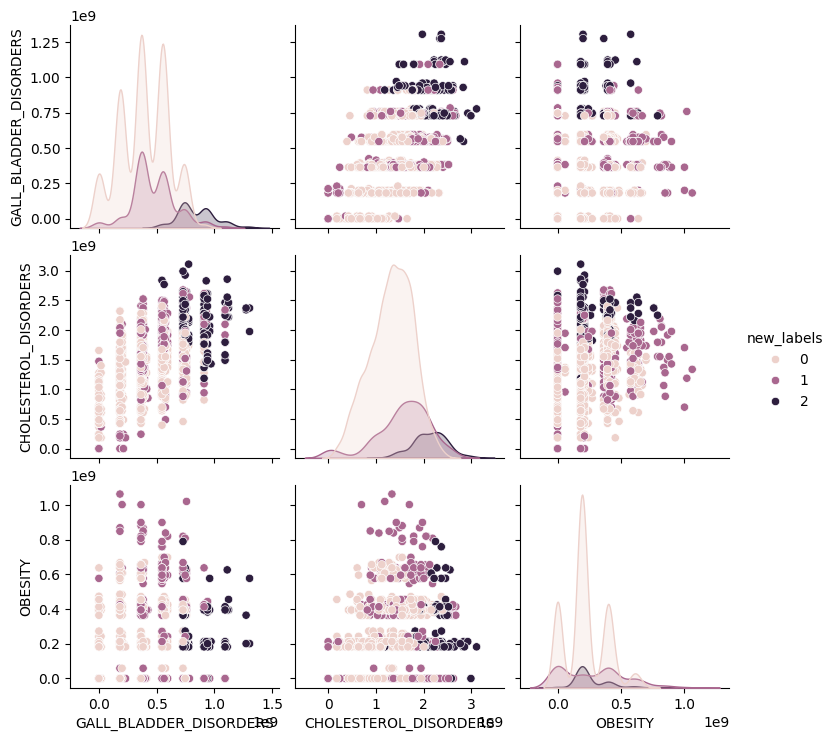

In [62]:
sns.pairplot(final_labeled, hue='new_labels')